In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# SINDy - Example 2: Lorenz system

Here we replicate example 2 of Brunton et al. 2016.
The Lorenz dynamics are:

\begin{align}
\dot{x} &= \sigma(y - x) \\
\dot{y} &= x(\rho - z) - y \\
\dot{z} &= xy - \beta z.
\end{align}

We take $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$.

We are going to experiment with adding noise to the derivatives.

In [4]:
import numpy as np
import scipy

sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
dt = 0.001
num_steps = int(100.0 / dt)
ts = np.linspace(0, 100, num_steps)
x0 = np.array([-8.0, 7.0, 27.0])

def vector_field(x, t):
    return (
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]
    )
xs = scipy.integrate.odeint(vector_field, x0, ts)

# Find the exact derivatives - no noise
from jax import vmap, jit
vf = jit(vmap(vector_field, in_axes=(0, 0)))
dxs = np.array(vf(xs, ts)).T

I had trouble replicating this problem using `LassoCV`. The inputs and outputs need scaling and even with scaling, it takes too many iterations to run and the results were not good.
I am going to use the sequentially thresholded least-squares approach suggested in the book [Brunton et al. 2019](http://databookuw.com/).
I reimplement the code from the book here:

In [5]:
def sparsify_dynamics(Phi, dxs, alpha, max_iter=100):
    """Solve the sparse regression problem to find the dynamics of the system.
    
    Args:
        Phi: The basis functions evaluated at each point in the state space.
        dxs: The time derivatives of the state space points.
        alpha: The sparsity parameter.
        max_iter: The maximum number of iterations to run the optimization.
    """
    thetas = np.linalg.lstsq(Phi, dxs, rcond=None)[0]
    d = dxs.shape[1]
    for _ in range(max_iter):
        smallinds = np.abs(thetas) < alpha
        thetas[smallinds] = 0
        for ind in range(d):
            biginds = smallinds[:, ind] == 0
            thetas[biginds, ind] = np.linalg.lstsq(Phi[:, biginds], dxs[:, ind], rcond=None)[0]
    return thetas

Solve the problem:

In [6]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=5)
Phi = poly.fit_transform(xs)

thetas = sparsify_dynamics(Phi, dxs, 0.025)

Let's look at the coefficients:

In [7]:
for j in range(thetas.shape[1]):
    print(f"Dynamics of x_{j+1}:")
    print("-" * 20)
    for i, name in enumerate(poly.get_feature_names_out()):
        print(f"{name:10s} = {thetas[i][j]:.2f}") 

Dynamics of x_1:
--------------------
1          = 0.00
x0         = -10.00
x1         = 10.00
x2         = 0.00
x0^2       = 0.00
x0 x1      = 0.00
x0 x2      = 0.00
x1^2       = 0.00
x1 x2      = 0.00
x2^2       = 0.00
x0^3       = 0.00
x0^2 x1    = 0.00
x0^2 x2    = 0.00
x0 x1^2    = 0.00
x0 x1 x2   = 0.00
x0 x2^2    = 0.00
x1^3       = 0.00
x1^2 x2    = 0.00
x1 x2^2    = 0.00
x2^3       = 0.00
x0^4       = 0.00
x0^3 x1    = 0.00
x0^3 x2    = 0.00
x0^2 x1^2  = 0.00
x0^2 x1 x2 = 0.00
x0^2 x2^2  = 0.00
x0 x1^3    = 0.00
x0 x1^2 x2 = 0.00
x0 x1 x2^2 = 0.00
x0 x2^3    = 0.00
x1^4       = 0.00
x1^3 x2    = 0.00
x1^2 x2^2  = 0.00
x1 x2^3    = 0.00
x2^4       = 0.00
x0^5       = 0.00
x0^4 x1    = 0.00
x0^4 x2    = 0.00
x0^3 x1^2  = 0.00
x0^3 x1 x2 = 0.00
x0^3 x2^2  = 0.00
x0^2 x1^3  = 0.00
x0^2 x1^2 x2 = 0.00
x0^2 x1 x2^2 = 0.00
x0^2 x2^3  = 0.00
x0 x1^4    = 0.00
x0 x1^3 x2 = 0.00
x0 x1^2 x2^2 = 0.00
x0 x1 x2^3 = 0.00
x0 x2^4    = 0.00
x1^5       = 0.00
x1^4 x2    = 0.00
x1^3 x2^2  = 0.00

It looks perfect! Let's now make predictions with the identified model.

In [8]:
dt = 0.001
num_steps = int(250.0 / dt)
ts = np.linspace(0, 250, num_steps)

# Simulate with the original dynamics
xs = scipy.integrate.odeint(vector_field, x0, ts)

# Simulate with the learned dynamics
def f_learned(x, t, thetas, poly):
    phi = poly.fit_transform(x.reshape(1, -1)).flatten()
    dx = np.zeros(x.shape[0])
    for j in range(x.shape[0]):
        dx[j] = np.dot(thetas[:, j], phi)
    return dx

xs_learned = scipy.integrate.odeint(lambda x, t: f_learned(x, t, thetas, poly), x0, ts)

Compare visually the attractors:

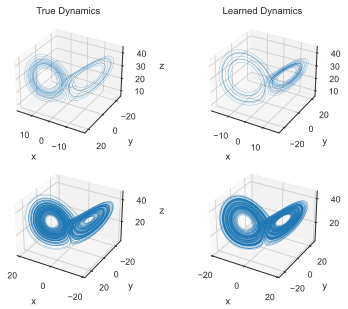

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')
steps = int(20/dt)
ax1.plot(xs[:steps, 0], xs[:steps, 1], xs[:steps, 2], lw=0.2)
ax1.set(xlabel='x', ylabel='y', zlabel='z', title='True Dynamics')
ax1.view_init(30, 120)

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot(xs_learned[:steps, 0], xs_learned[:steps, 1], xs_learned[:steps, 2], lw=0.2)
ax2.set(xlabel='x', ylabel='y', zlabel='z', title='Learned Dynamics')
ax1.view_init(30, 120)

ax3 = fig.add_subplot(223, projection='3d')
ax3.plot(xs[:, 0], xs[:, 1], xs[:, 2], lw=0.2)
ax3.set(xlabel='x', ylabel='y', zlabel='z')
ax3.view_init(30, 120)

ax4 = fig.add_subplot(224, projection='3d')
ax4.plot(xs_learned[:, 0], xs_learned[:, 1], xs_learned[:, 2], lw=0.2)
ax4.set(xlabel='x', ylabel='y', zlabel='z')
ax3.view_init(30, 120);

This replicates the the first two columns of Fig. 4 in Brunton et al. 2016 (sans the color and the noise).
You see that the dynamics do not match perfectly (because the system is chaotic), but the attractors are very similar.

Let's also plot the dynamo view:

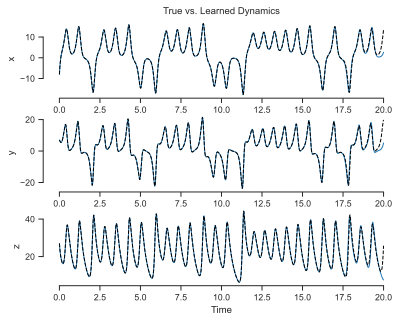

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
steps = int(20/dt)
ax1.plot(ts[:steps], xs[:steps, 0], lw=1.0, label='True Dynamics')
ax1.plot(ts[:steps], xs_learned[:steps, 0], 'k--', lw=1.0, label='Learned Dynamics')
ax1.set(xlabel='Time', ylabel='x', title='True vs. Learned Dynamics')
sns.despine(trim=True);

ax2 = fig.add_subplot(312)
ax2.plot(ts[:steps], xs[:steps, 1], lw=1.0, label='True Dynamics')
ax2.plot(ts[:steps], xs_learned[:steps, 1], 'k--', lw=1.0, label='Learned Dynamics')
ax2.set(xlabel='Time', ylabel='y')

ax3 = fig.add_subplot(313)
ax3.plot(ts[:steps], xs[:steps, 2], lw=1.0, label='True Dynamics')
ax3.plot(ts[:steps], xs_learned[:steps, 2], 'k--', lw=1.0, label='Learned Dynamics')
ax3.set(xlabel='Time', ylabel='z')
sns.despine(trim=True);

This reproduces Fig. 5 in Brunton et al. 2016 (sans the noise).

Let's repeat the same analysis, but this time we are going to add noise to the derivatives. The noise is zero mean, independent Gaussian with standard deviation $\eta$.

In [11]:
# Noise level:
eta = 10.0

dxs_noisy = dxs + eta * np.random.randn(*dxs.shape)

# retrain
thetas_noisy = sparsify_dynamics(Phi, dxs_noisy, 0.025)

Repeat the plots above:

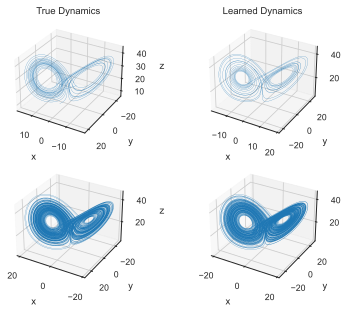

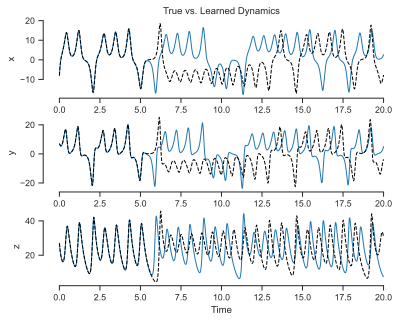

In [12]:
xs_learned = scipy.integrate.odeint(lambda x, t: f_learned(x, t, thetas_noisy, poly), x0, ts)

fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')
steps = int(20/dt)
ax1.plot(xs[:steps, 0], xs[:steps, 1], xs[:steps, 2], lw=0.2)
ax1.set(xlabel='x', ylabel='y', zlabel='z', title='True Dynamics')
ax1.view_init(30, 120)

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot(xs_learned[:steps, 0], xs_learned[:steps, 1], xs_learned[:steps, 2], lw=0.2)
ax2.set(xlabel='x', ylabel='y', zlabel='z', title='Learned Dynamics')
ax1.view_init(30, 120)

ax3 = fig.add_subplot(223, projection='3d')
ax3.plot(xs[:, 0], xs[:, 1], xs[:, 2], lw=0.2)
ax3.set(xlabel='x', ylabel='y', zlabel='z')
ax3.view_init(30, 120)

ax4 = fig.add_subplot(224, projection='3d')
ax4.plot(xs_learned[:, 0], xs_learned[:, 1], xs_learned[:, 2], lw=0.2)
ax4.set(xlabel='x', ylabel='y', zlabel='z')
ax3.view_init(30, 120);

fig = plt.figure()
ax1 = fig.add_subplot(311)
steps = int(20/dt)
ax1.plot(ts[:steps], xs[:steps, 0], lw=1.0, label='True Dynamics')
ax1.plot(ts[:steps], xs_learned[:steps, 0], 'k--', lw=1.0, label='Learned Dynamics')
ax1.set(xlabel='Time', ylabel='x', title='True vs. Learned Dynamics')
sns.despine(trim=True);

ax2 = fig.add_subplot(312)
ax2.plot(ts[:steps], xs[:steps, 1], lw=1.0, label='True Dynamics')
ax2.plot(ts[:steps], xs_learned[:steps, 1], 'k--', lw=1.0, label='Learned Dynamics')
ax2.set(xlabel='Time', ylabel='y')

ax3 = fig.add_subplot(313)
ax3.plot(ts[:steps], xs[:steps, 2], lw=1.0, label='True Dynamics')
ax3.plot(ts[:steps], xs_learned[:steps, 2], 'k--', lw=1.0, label='Learned Dynamics')
ax3.set(xlabel='Time', ylabel='z')
sns.despine(trim=True);

We see that the particular trajectories are not accurate after a while.
The system is chaotic, so this is expected.
Tiny errors will be magnified over time.
But the attractor looks great.